In [17]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch
import cv2
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import yaml

In [2]:
class ImageDatasetwithCV(Dataset):

    def __init__(self,root_dir,mode="RGB",transform=None):
        self.root_dir = root_dir
        self.mode = mode.lower()
        self.transform = transform

        self.class_to_idx = {}
        self.samples = []

        classes = sorted(os.listdir(root_dir))
        for idx , cls in enumerate(classes):

            self.class_to_idx[cls] = idx

            cls_dir = os.path.join(root_dir,cls)

            for file in os.listdir(cls_dir):
                self.samples.append((os.path.join(cls_dir,file),idx))

    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        img_path , label = self.samples[index]

        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        if self.mode == "gray":
            img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            img = img[...,None]

        elif self.mode == "clahe":
            lab = cv2.cvtColor(img,cv2.COLOR_RGB2LAB)
            l , a , b = cv2.split(lab)
            clahe = cv2.createCLAHE(2.0,(8,8))
            l = clahe.apply(l)
            img = cv2.merge((l,a,b))
            img = cv2.cvtColor(img,cv2.COLOR_Lab2RGB)

        elif self.mode == "edges":
            gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            img = cv2.Canny(gray,100,200)[...,None]

        
        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(img)

        if img.ndim == 2:
            img = img[...,None]

        img.permute(2,0,1)

        if img.shape[0] == 1:
            img = img.repeat(3,1,1)
        
        if self.transform:
            img = self.transform(img)

        
        return img , label


In [3]:
root_dir = "C:/Users/MUIN/Desktop/Ali/Deepfake_detection/Final_Dataset"
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [4]:
full_dataset = ImageDatasetwithCV(root_dir=root_dir,mode="gray",transform=transform)

In [5]:
print(len(full_dataset))

12890


In [6]:
def get_optimized_dataset(raw_dataset_path, save_path, mode="RGB", transform=None):

    if os.path.exists(save_path):
        print(f"--- Loading processed data from {save_path} ---")
        data = torch.load(save_path)
        return TensorDataset(data["images"], data["labels"])

    else:
        print(f"--- No saved data found. Processing with OpenCV ({mode})... ---")

        # Use your existing class
        processed_set = ImageDatasetwithCV(
            raw_dataset_path, mode=mode, transform=transform
        )

        all_imgs = []
        all_labels = []

        for i in tqdm(range(len(processed_set))):
            img_tensor, label = processed_set[i]
            all_imgs.append(img_tensor)
            all_labels.append(label)

        images_tensor = torch.stack(all_imgs)
        labels_tensor = torch.tensor(all_labels)

        # 3. Save for next time
        print(f"--- Saving processed data to {save_path} ---")
        torch.save({"images": images_tensor, "labels": labels_tensor}, save_path)

        return TensorDataset(images_tensor, labels_tensor)

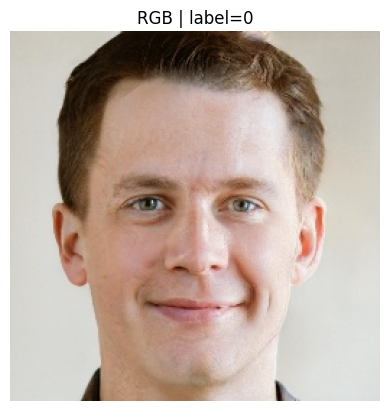

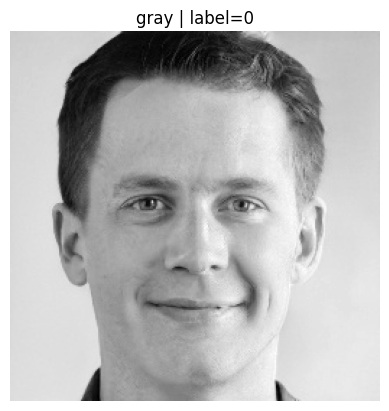

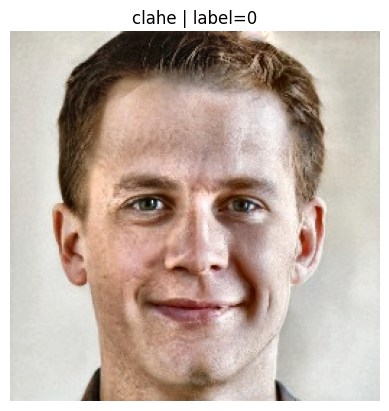

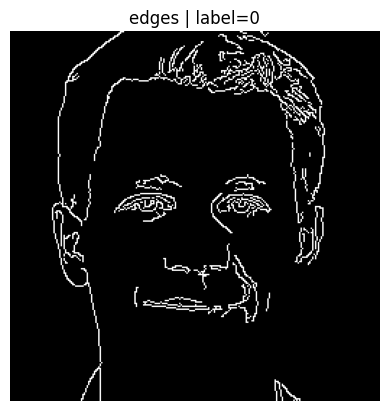

In [16]:
modes = ["RGB","gray","clahe","edges"]

for m in modes :
    ds = ImageDatasetwithCV(root_dir=root_dir,mode=m)
    img , label = ds[8]

    plt.imshow(img,cmap="gray") 
    plt.title(f"{m} | label={label}")
    plt.axis(False)
    plt.show()

In [39]:
with open("C:/Users/MUIN/Desktop/Ali/Deepfake_detection/configs/config.yaml","r") as f:
    config = yaml.safe_load(f)

print(config)

{'save_dir': 'data/', 'save_paths': {'gray': 'gray_data.pt', 'clahe': 'clahe_data.pt', 'edges': 'edges_data.pt', 'RGB': 'RGB_data.pt'}}


In [40]:
save_dir = config["save_dir"]
save_paths = config["save_paths"]
save_paths["gray"]

'gray_data.pt'

In [41]:
print(os.path.join(save_dir,save_paths["gray"]))

data/gray_data.pt
